In [1]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tueplots  import figsizes

import sys
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [2]:
from analysis import sweep2df

In [3]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [128]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "aparoxur"


In [129]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"moebius_sweep_{SWEEP_ID}.csv"

In [130]:
runs_df = sweep2df(sweep.runs, filename, True,load=False)

IndexError: single positional indexer is out-of-bounds

In [131]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,mse_obs_decoded_mean_latents,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
2,fluent-sweep-114,3,100000.0,-3.640918,-8.714379,12.355302,uniform,0.000936,0.969670,0.000156,...,0.274316,0.007393,0.009558,0.001937,0.047193,0.044481,0.098077,0.000212,0.000225,0.000102
3,atomic-sweep-116,3,100000.0,-3.996430,-8.473587,12.470016,uniform,0.001027,0.970464,0.000728,...,0.159183,0.005522,0.008229,0.007855,0.054120,0.045492,0.050592,0.000185,0.000220,0.000198
4,laced-sweep-114,3,100000.0,-3.747862,-8.485846,12.233707,uniform,0.003681,0.946228,0.000269,...,0.045951,0.007410,0.007825,0.008242,0.050532,0.049638,0.051911,0.000198,0.000201,0.000193
5,ancient-sweep-112,3,100000.0,-3.586784,-8.464359,12.051142,uniform,0.003386,0.951198,0.000124,...,0.136959,0.007778,0.008751,0.005789,0.049475,0.044894,0.054576,0.000202,0.000223,0.000183
6,spring-sweep-113,3,100000.0,-3.934934,-8.590427,12.525364,uniform,0.002835,0.962819,0.001381,...,0.086533,0.007939,0.007793,0.004224,0.048887,0.045082,0.070696,0.000205,0.000222,0.000141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,hearty-sweep-16,3,10.0,-0.628291,-0.029677,0.657968,uniform,1.681410,0.149829,0.419867,...,0.002663,3.051715,3.196243,3.118419,0.000015,0.000017,0.000044,6813.537006,5913.999350,2263.865816
102,worldly-sweep-14,3,10.0,-0.629037,-0.028636,0.657673,uniform,2.732165,0.152009,0.672617,...,0.003187,3.133762,3.053871,3.105312,0.000034,0.000049,0.000043,2946.676136,2028.687045,2347.593478
103,electric-sweep-13,3,10.0,-0.629196,-0.028810,0.658006,uniform,0.139535,0.151928,0.139535,...,0.002722,2.980591,3.030186,2.984174,0.000033,0.000041,0.000009,3024.593273,2462.646376,11314.802235
104,amber-sweep-5,3,10.0,-0.630610,-0.026974,0.657584,uniform,2.011273,0.147999,0.895605,...,0.003388,3.030219,3.165489,3.011441,0.000026,0.000054,0.000005,3847.065156,1842.198024,19432.445254


In [119]:
runs_df = runs_df[runs_df.gamma_square <= 1e5]

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [122]:
runs_df[[ "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

cima4min_neg_elbo                                          \
                         count      mean       std       min       25%   
gamma_square                                                             
10.0                      20.0  1.335482  0.564094  0.611589  0.792626   
100.0                     20.0  1.236132  0.559228  0.450587  0.768593   
1000.0                    19.0  0.068911  0.139163  0.002055  0.002738   
10000.0                   15.0  0.001613  0.000886  0.000733  0.000937   
100000.0                  12.0  0.003683  0.003522  0.000571  0.001451   

                                            
                   50%       75%       max  
gamma_square                                
10.0          1.350295  1.737893  2.397702  
100.0         1.049250  1.718161  2.334175  
1000.0        0.004156  0.007729  0.444581  
10000.0       0.001533  0.002020  0.003491  
100000.0      0.002916  0.004132  0.012824

In [14]:
runs_df[[ "mcc4min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

mcc4min_neg_elbo                                          \
                        count      mean       std       min       25%   
gamma_square                                                            
10.0                     20.0  0.152054  0.002594  0.145711  0.150620   
100.0                    20.0  0.150781  0.003009  0.144056  0.149297   
1000.0                   19.0  0.711884  0.095085  0.529063  0.738003   
10000.0                  15.0  0.960604  0.008021  0.945257  0.954726   
100000.0                  8.0  0.961928  0.006590  0.951066  0.959291   
1000000.0                19.0  0.874615  0.078698  0.681927  0.835355   

                                            
                   50%       75%       max  
gamma_square                                
10.0          0.151827  0.153587  0.156768  
100.0         0.150826  0.152549  0.156737  
1000.0        0.758195  0.764575  0.773091  
10000.0       0.961280  0.967258  0.972414  
100000.0      0.960931  0.965914  0.972617  
1000000.0     0.892959  0.925237  0.966841

In [123]:
runs_df[[ "min_neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

min_neg_elbo                                                    \
                    count      mean       std       min       25%       50%   
gamma_square                                                                  
10.0                 20.0 -0.631330  0.001146 -0.633572 -0.632227 -0.631218   
100.0                20.0 -3.733695  0.001176 -3.736262 -3.734592 -3.733493   
1000.0               19.0 -4.696911  0.014440 -4.711015 -4.707474 -4.705772   
10000.0              15.0 -4.734727  0.121436 -4.889158 -4.822603 -4.767874   
100000.0             12.0 -3.856143  0.319052 -4.231724 -4.126556 -3.892644   

                                  
                   75%       max  
gamma_square                      
10.0         -0.630326 -0.629624  
100.0        -3.732953 -3.731812  
1000.0       -4.687442 -4.660370  
10000.0      -4.644563 -4.476871  
100000.0     -3.697896 -3.312922

In [16]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [17]:
df_mse_sources_mean_decoded_sources = pd.DataFrame(runs_df[[col for col in runs_df.columns if col == "mse_sources_mean_decoded_sources"]].stack().droplevel(1), columns=["mse_sources_mean_decoded_sources"])
df_mse_obs_decoded_mean_latents = pd.DataFrame(runs_df[[col for col in runs_df.columns if col == "mse_obs_decoded_mean_latents"]].stack().droplevel(1), columns=["mse_obs_decoded_mean_latents"])
df_mse_gamma_sq = df_mse_sources_mean_decoded_sources.merge( df_mse_obs_decoded_mean_latents, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

In [49]:
def format_violin(vp, facecolor='#1A85FF'):
    for el in vp['bodies']:
        el.set_facecolor(facecolor)
        el.set_edgecolor('black')
        el.set_linewidth(1.5)
        el.set_alpha(.9)
    for pn in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        vp_ = vp[pn]
        vp_.set_edgecolor('black')
        vp_.set_linewidth(1)

In [44]:
def create_violinplot(groups, xlabel, ylabel, xticklabels, filename=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax.twinx()

    vp= ax.violinplot(groups, showmedians=True)
    format_violin(vp, '#1A85FF')

    ax.set_xticklabels(xticklabels)
    # ax.set_xticks(xticks)
    # plt.locator_params(axis='y', nbins=5)
    # plt.yticks(fontsize=24)
    # plt.ylim([0, 0.5])
    ax.set_ylabel(ylabel)
    # ax.set_xlabel(xlabel)
    if filename is not None:
        plt.savefig(f"{filename}.svg")
    return ax

In [126]:
elbo_filter = runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()['neg_elbo']['max']
groups = [g for _, g in runs_df[[ "neg_elbo", "mcc4min_neg_elbo", "cima4min_neg_elbo", "gamma_square"]].groupby("gamma_square")]
gg_mcc = [g[g.neg_elbo <= threshold].mcc4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_cima = [g[g.neg_elbo <= threshold].cima4min_neg_elbo  for g, threshold in zip(groups, elbo_filter)]
gg_gamma = [g[g.neg_elbo <= threshold].gamma_square  for g, threshold in zip(groups, elbo_filter)]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_25805/852160804.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()))


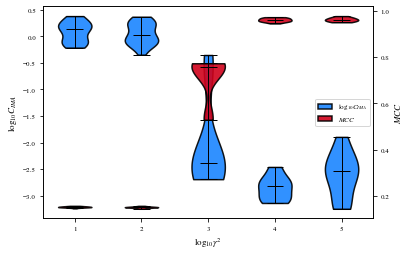

In [127]:
fig, ax = plt.subplots(figsize=figsizes.neurips2022(nrows=1, ncols=1)['figure.figsize'])
ax2 = ax.twinx()

vp= ax.violinplot([np.log10(g) for g in gg_cima], showmedians=True)
format_violin(vp)
ax.set_ylabel("$\log_{10} C_{IMA}$")

vp2= ax2.violinplot(gg_mcc, showmedians=True)
format_violin(vp2,'#D0021B')
ax2.set_ylabel("$MCC$")

ax.set_xlabel("$\log_{10}\gamma^2$")
ax.set_xticklabels([0]+ sorted(np.log10(runs_df["gamma_square"]).astype(int).unique()))
plt.legend([vp['bodies'][0],vp2['bodies'][0]], ["$\log_{10} C_{IMA}$", "$MCC$"], loc='right')

plt.savefig("moebius_mcc_cima.svg")

In [ ]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)